Input:
- Model Parameter: population, alpha,
- Ggf. Calculation r-value (traditional, neural network, lstm)

Output:
- Calculated/Predicted Observation

In [109]:
import torch
from torch import optim
from torch import distributions
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import imageio
import os

In [110]:
#%cd master-thesis

In [111]:
#%cd ..

In [129]:
def epidim_model(population, R):
        n = R.size()[0]
        dtype = torch.float32
        #device = torch.device("cuda")
        df_si_dd = pd.read_csv('data/si_and_dd_covid19model.csv', sep=',', decimal='.', encoding='utf-8', dtype={'serial_interval': np.float64, 'delay_distr': np.float64})
        si = torch.tensor(df_si_dd['serial_interval'][0:n],dtype=dtype)
        dd =  torch.tensor(df_si_dd['delay_distr'][0:n],dtype=dtype)
        # Seed initial Infections
        newly_infected = torch.zeros(n, dtype=dtype)
        # number of newly infected
        cumulative_infected = torch.zeros(n,dtype=dtype)
        #cumulative number of infected
        immune = torch.zeros(n,dtype=dtype)
        St = torch.ones(n,dtype=dtype)  # fraction of susceptible population
        effectively_infectious = torch.zeros(n,dtype=dtype)
        cero = torch.tensor(0.,dtype=dtype)
        num_impute=6
        newly_infected[0:num_impute] = torch.tensor(1.,dtype=dtype)
        cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)

        immune[0:num_impute] = cumulative_infected[0:num_impute].clone() #+ vaccine_inmune[0:num_impute].clone()
        # TODO: Add vaccine
        for t in range(num_impute, n):
                # Update cumulative newly_infected
                cumulative_infected[t] = cumulative_infected[t - 1] + newly_infected[t - 1]
                immune[t] = cumulative_infected[t] #+ vaccine_inmune[t]
                # Adjusts for portion of pop that are susceptible
                St[t] = torch.maximum(population - immune[t], cero) / population
                # effective number of infectous individuals
                ni_temp = newly_infected[:t].view(1, 1, -1).clone()
                si_temp = torch.flip(si, (0,))[-t:].view(1, 1, -1)
                effectively_infectious[t] = torch.nn.functional.conv1d(ni_temp, si_temp)

                newly_infected[t] = St[t].clone() * R[t] * effectively_infectious[t].clone()

        return {'St': St, 'newly': newly_infected, 'cumulative': cumulative_infected}

In [131]:
population = 100000
n = 400
R = 2*torch.rand(n)

observations = epidim_model(population,R)

In [138]:
lista =[]
for i in np.arange(0,3,0.2):
        n=400
        R = 2*torch.rand(n)
        observations = epidim_model(population,R)
        observations['i'] = i
        lista.append(observations)
df = pd.DataFrame(lista)


In [ ]:
import plotly.express as px
fig = px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.show()

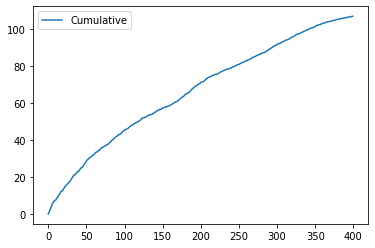

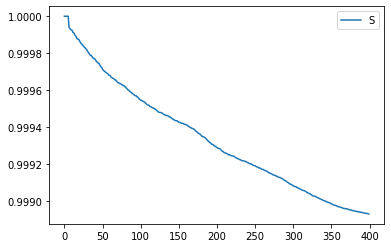

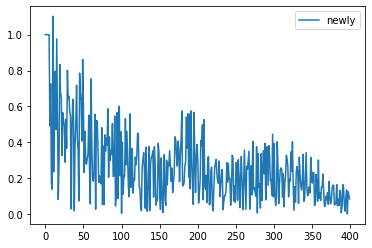

In [132]:
import matplotlib.pyplot as plt

plt.plot(observations['cumulative'],label='Cumulative')
plt.legend()
plt.show()
plt.plot(observations['St'],label='S')
plt.legend()
plt.show()population = 100000
n = 400
R = 2*torch.rand(n)
plt.plot(observations['newly'],label='newly')
plt.legend()
plt.show()